# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Francisca Burgos

* __Rol__: 201810517-1

2.- Debes _pushear_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
    - Soluciones
    - Código
    - Que Binder esté bien configurado.
    - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

import timeit
import time

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from metrics_classification import *
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada!
Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

Sacaremos la columna "target" momentaneamente ya que no es relevante para utilizar la funcion .describe()

In [6]:
digits.describe().drop("target", axis = 1, inplace = False)

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c54,c55,c56,c57,c58,c59,c60,c61,c62,c63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


#### ¿Cómo se distribuyen los datos?

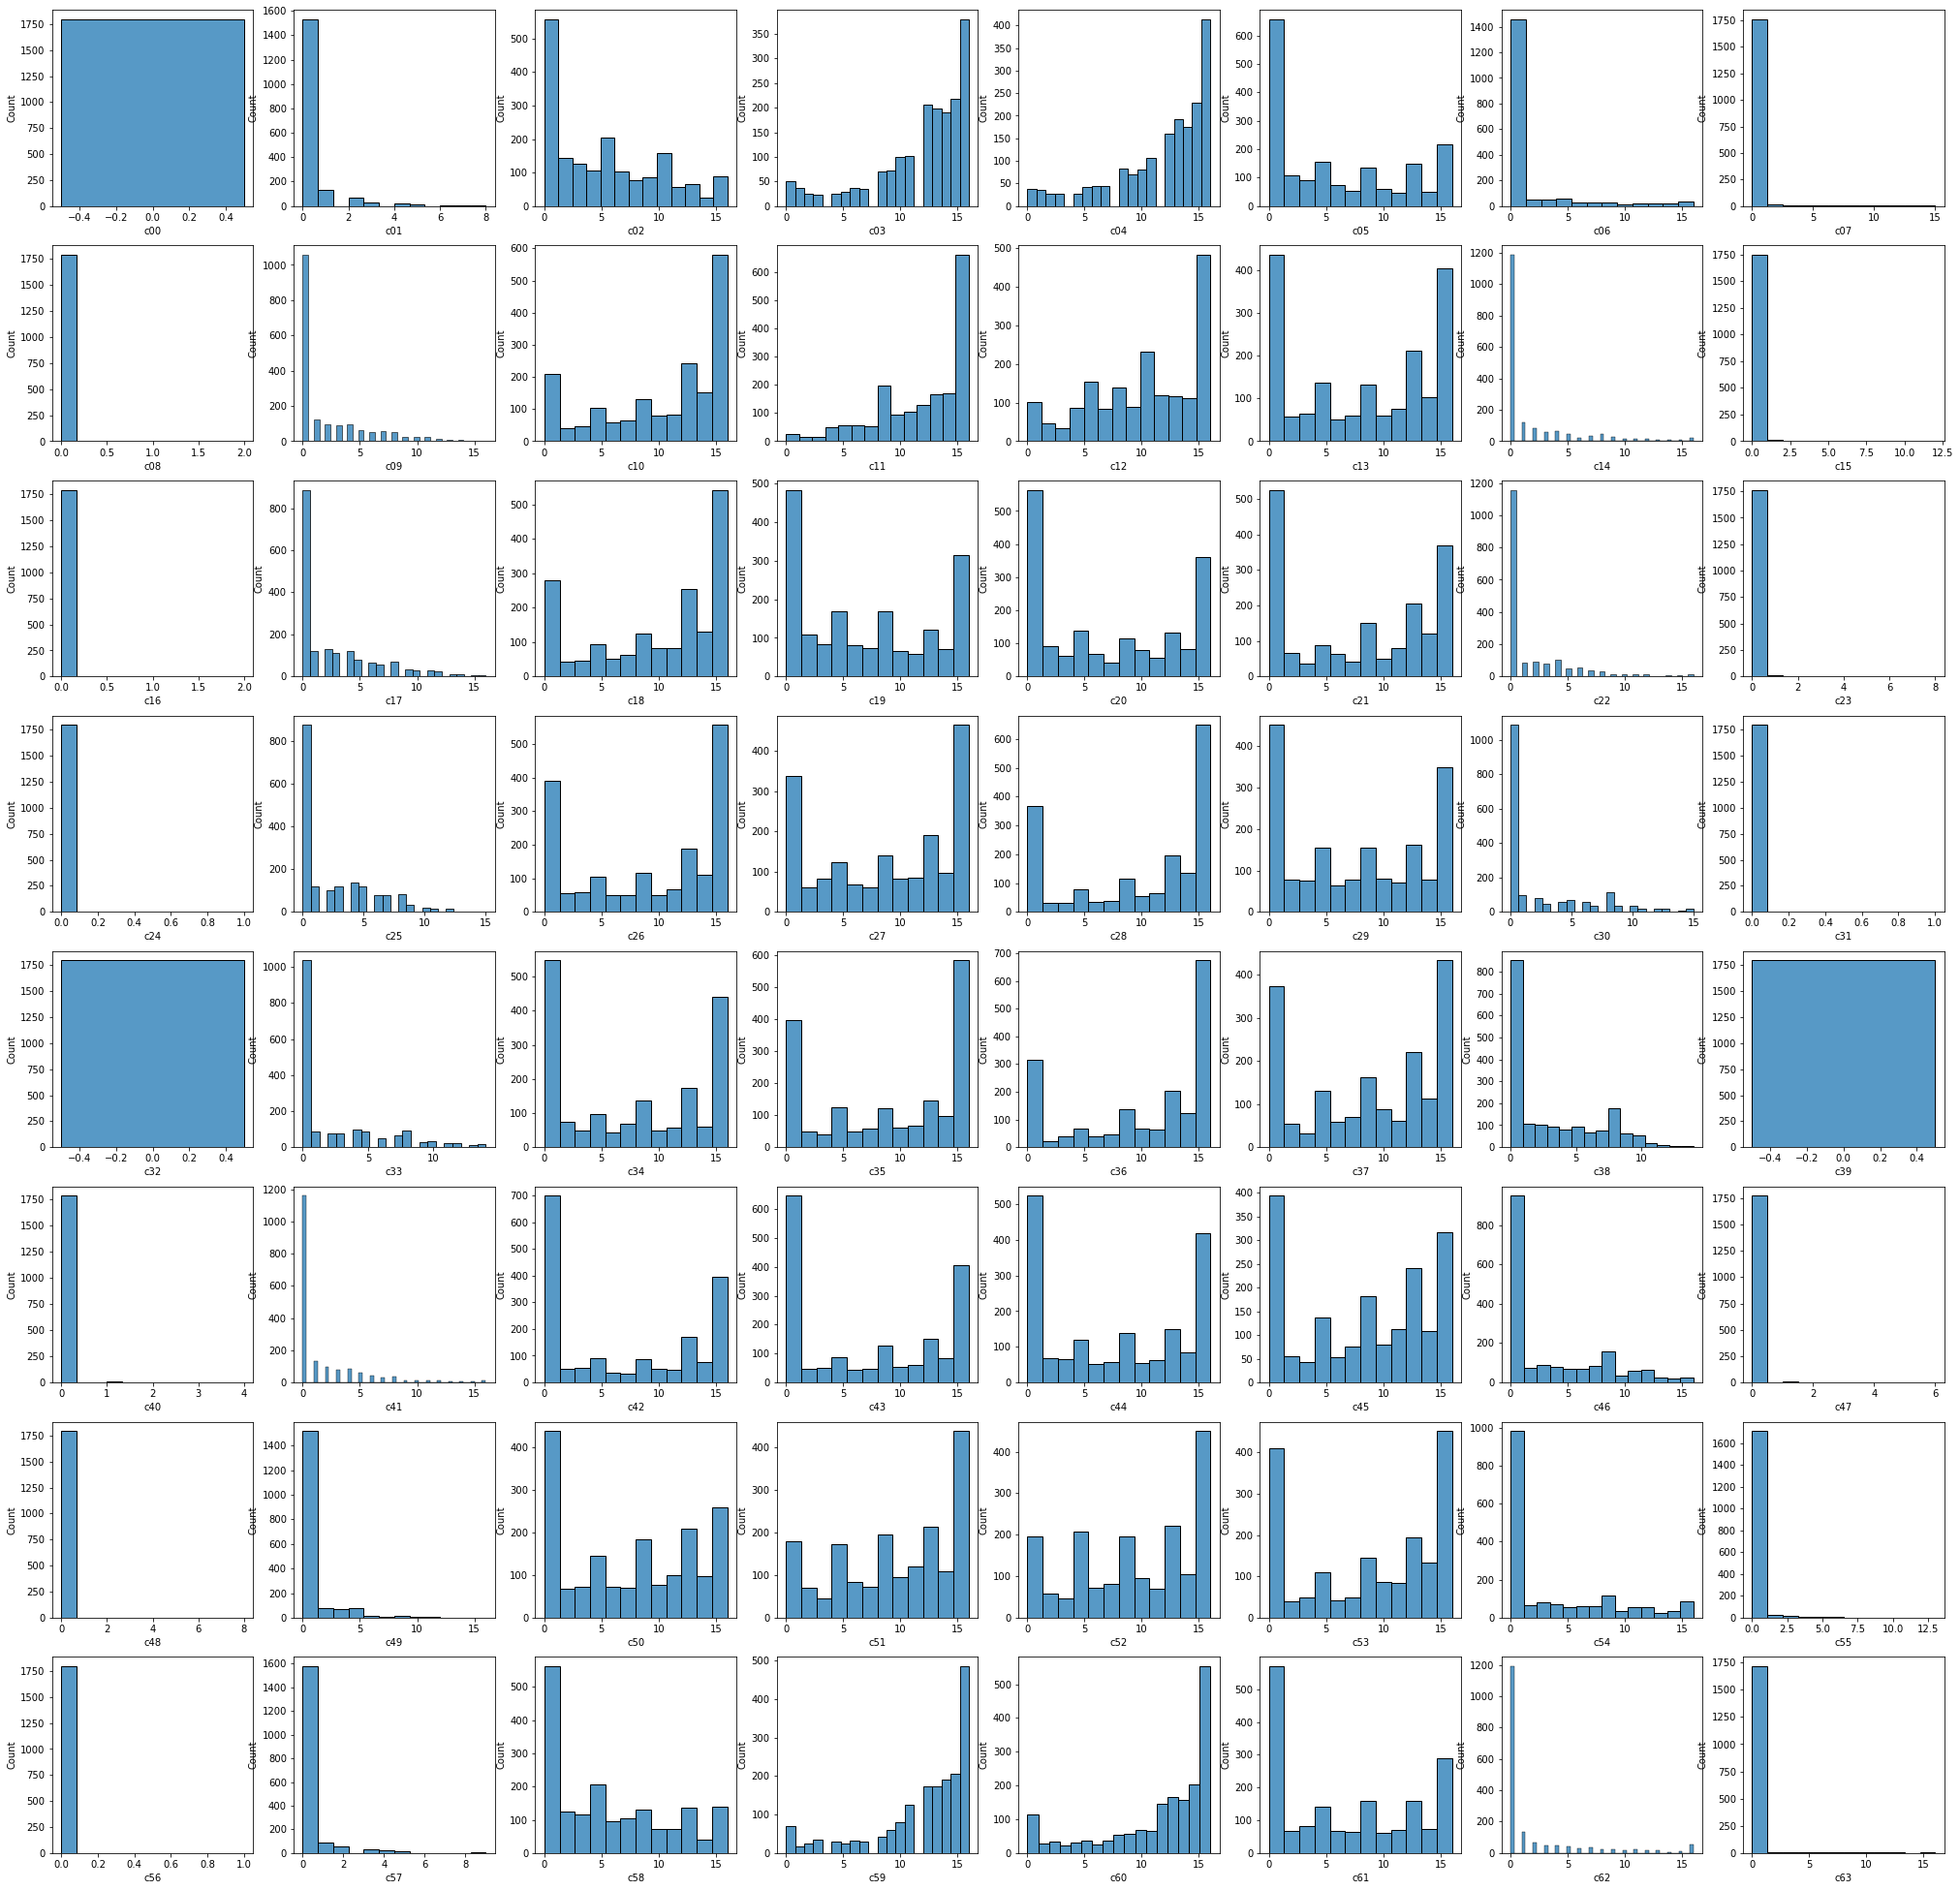

In [7]:
columnas = digits.columns # obtenemos cada columna del data

nx, ny = 8, 8
fig, axs = plt.subplots(nx,ny, figsize = (35,35))

for i in range(0,64): #la columna "target" la haremos despues
    plt.subplot(nx,ny,i+1)
    sns.histplot(digits[columnas[i]])

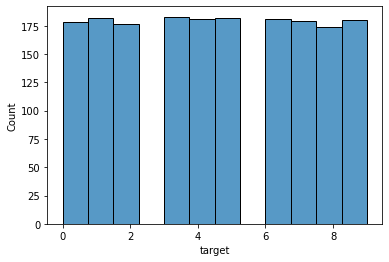

In [8]:
fig = figsize = (30,30)
sns.histplot(digits[columnas[64]])
plt.show()

#### ¿Cuánta memoria estoy utilizando?

In [9]:
print(digits.memory_usage().sum(), "bytes")

467348 bytes


#### ¿Qué tipo de datos son?

In [10]:
digits.dtypes.unique()

array([dtype('int32')], dtype=object)

Todos los datos son enteros pero hay que considerar que la columna "target" representa el numero que componen las columnas.

#### ¿Cuántos registros por clase hay?

In [11]:
#registros por clase
print("Hay", digits.shape[0], "registros por clase")

Hay 1797 registros por clase


#### ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [12]:
digits.isnull().values.any()

False

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [13]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

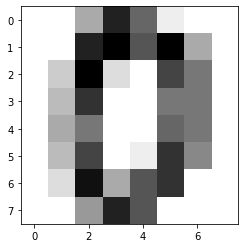

In [14]:
plt.imshow(digits_dict["images"][0],cmap='gray_r')

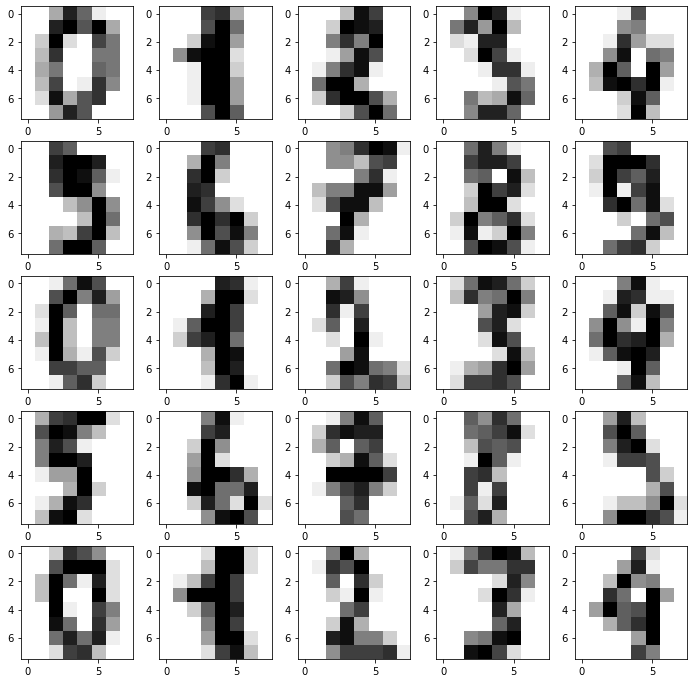

In [15]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for i in range(1,26):  #para las primeras 25 filas
    plt.subplot(nx,ny,i)
    plt.imshow(digits_dict["images"][i-1],cmap='gray_r')  #en escala de grises

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [16]:
# librerias
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from metrics_classification import *
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn import svm
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_digits
from sklearn.model_selection import validation_curve

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

#### train-test

In [17]:
X = digits.drop(columns="target").values
Y = digits["target"].values

In [18]:
# split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)

In [19]:
# print rows train and test sets
print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1257
numero de filas test set      :  540


### MODELO 1: Logistic Regression

#### modelo

In [20]:
# creación del modelo
model1 = LogisticRegression()

# rango de parametros
param_grid1 = {'penalty': ['l1', 'l2', 'elasticnet'], 'C':[0.01,0.1,1,10]}

# aplicar greed search
gs1 = GridSearchCV(estimator=model1, 
                  param_grid=param_grid1)

gs1 = gs1.fit(X_train, Y_train)

# imprimir resultados
print("Best: %f con %s" % (gs1.best_score_, gs1.best_params_))

Best: 0.957032 con {'C': 0.01, 'penalty': 'l2'}


In [21]:
# utilizando el mejor modelo
mejor_modelo1 = gs1.best_estimator_
#mejor_modelo1.fit(X_train, Y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo1.score(X_test, Y_test)))

Precisión: 0.970


#### métricas

In [22]:
Y_pred = mejor_modelo1.predict(X_test)#Predicción del modelo
print('La matriz de confusión asociada es: \n \n',confusion_matrix(Y_test,Y_pred), '\n \n y las métricas son:')
df1 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred
    }
)

summary_metrics(df1)

La matriz de confusión asociada es: 
 
 [[53  0  0  0  0  0  0  0  0  0]
 [ 0 46  2  0  0  0  0  0  2  0]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  0 51  0  1  0  0  2  0]
 [ 0  1  0  0 59  0  0  0  0  0]
 [ 0  0  1  0  0 63  1  0  0  1]
 [ 0  0  0  0  0  1 52  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  1]
 [ 0  0  0  0  0  1  0  0 42  0]
 [ 0  0  0  1  0  0  0  0  1 57]] 
 
 y las métricas son:


,accuracy,recall,precision,fscore
0,0.9704,0.9708,0.9695,0.9697


### MODELO 2: K-Nearest Neighbors

#### modelo

In [23]:
# creación del modelo
model2 = KNeighborsClassifier()

# rango de parametros
param_grid2 = {'n_neighbors':[0.01,0.1,1,10]}

# aplicar greed search
gs2 = GridSearchCV(estimator=model2, 
                  param_grid=param_grid2)

gs2 = gs2.fit(X_train, Y_train)

# imprimir resultados
print("Best: %f con %s" % (gs2.best_score_, gs2.best_params_))

Best: 0.986476 con {'n_neighbors': 1}


In [24]:
# utilizando el mejor modelo
mejor_modelo2 = gs2.best_estimator_
#mejor_modelo2.fit(X_train, Y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo2.score(X_test, Y_test)))

Precisión: 0.983


#### métricas

In [25]:
Y_pred = mejor_modelo2.predict(X_test)#Predicción del modelo
print('La matriz de confusión asociada es: \n \n',confusion_matrix(Y_test,Y_pred), '\n \n y las métricas son:')
df2 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred
    }
)
summary_metrics(df2)

La matriz de confusión asociada es: 
 
 [[53  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  0 53  0  0  0  0  1  0]
 [ 0  1  0  0 59  0  0  0  0  0]
 [ 0  0  0  0  0 65  0  0  0  1]
 [ 0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  1]
 [ 0  1  0  0  0  0  0  0 41  1]
 [ 0  0  0  2  1  0  0  0  0 56]] 
 
 y las métricas son:


,accuracy,recall,precision,fscore
0,0.9833,0.9834,0.9834,0.9833


### MODELO 3: SVC

#### modelo

In [26]:
# creación del modelo
model3 = SVC()

# rango de parametros
param_grid3 = parameters = {'kernel':('linear', 'rbf'), 'C':[0.01,0.1,1,10]}

# aplicar greed search
gs3 = GridSearchCV(estimator=model3, 
                  param_grid=param_grid3)

gs3 = gs3.fit(X_train, Y_train)

# imprimir resultados
print("Best: %f con %s" % (gs3.best_score_, gs3.best_params_))

Best: 0.990460 con {'C': 10, 'kernel': 'rbf'}


In [27]:
# utilizando el mejor modelo
mejor_modelo3 = gs3.best_estimator_
#mejor_modelo3.fit(X_train, Y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo3.score(X_test, Y_test)))

Precisión: 0.989


#### métricas

In [28]:
Y_pred = mejor_modelo3.predict(X_test)#Predicción del modelo
print('La matriz de confusión asociada es: \n \n',confusion_matrix(Y_test,Y_pred), '\n \n y las métricas son:')
df3 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred
    }
)
summary_metrics(df3)

La matriz de confusión asociada es: 
 
 [[53  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  1 52  0  1  0  0  0  0]
 [ 0  0  0  0 60  0  0  0  0  0]
 [ 0  0  0  0  0 65  0  0  0  1]
 [ 0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  1]
 [ 0  0  0  0  0  0  0  0 43  0]
 [ 0  0  0  0  0  0  0  1  1 57]] 
 
 y las métricas son:


,accuracy,recall,precision,fscore
0,0.9889,0.9896,0.9889,0.9892


#### ¿Cuál modelo es mejor basado en sus métricas?

In [29]:
comparar = pd.concat([summary_metrics(df1),summary_metrics(df2),summary_metrics(df3)])
comparar["model"] = ["Logistic Regression","K-NN","SVC"]
comparar

,accuracy,recall,precision,fscore,model
0,0.9704,0.9708,0.9695,0.9697,Logistic Regression
0,0.9833,0.9834,0.9834,0.9833,K-NN
0,0.9889,0.9896,0.9889,0.9892,SVC


SVC es la que tiene mejores metricas.

#### ¿Cuál modelo demora menos tiempo en ajustarse?

In [30]:
%timeit mejor_modelo1.fit(X_train, Y_train)

93 ms ± 9.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%timeit mejor_modelo2.fit(X_train, Y_train)

211 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%timeit mejor_modelo3.fit(X_train, Y_train)

33.5 ms ± 946 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


El que se demora menos tiempo en ajustarse es K-NN. Luego le sigue SVC y finalmente Logistic Regression.

#### ¿Qué modelo escoges?

SVC ya que fue el que tuvo mejores metricas, un 99% aprox de precision.

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

#### Cross validation:

In [33]:
precision = cross_val_score(estimator=model3,
                            X=X_train,
                            y=Y_train,
                            cv=10)

print('{0: .2f} +/- {1: .2f}'.format(np.mean(precision), np.std(precision)))

 0.99 +/-  0.01


#### Curva de Validación:

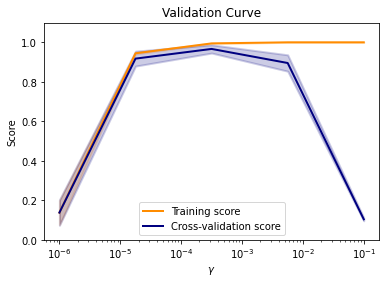

In [34]:
X, Y = load_digits(return_X_y=True)

param_range = np.logspace(-6, -1, 5)

train_scores, test_scores = validation_curve(
    SVC(),
    X,
    Y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=1,
    cv=10
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")

plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)

plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)

plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)

plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)

plt.legend(loc="best")
plt.show()

#### Curva AUC–ROC:

In [35]:
#Curva AUC–ROC

random_state = np.random.RandomState(0)

# Binarize the output
yb = label_binarize(Y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
n_classes = yb.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, yb, test_size=0.5, random_state=0)


# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

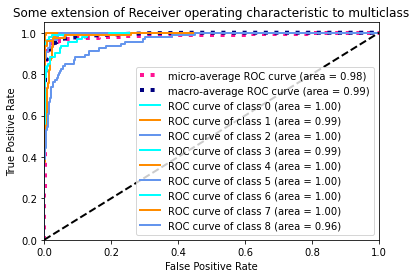

In [36]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una reducción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [37]:
# Librerias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

### Selección de atributos

In [38]:
contador=0
lista = []
for i in columnas:
    if digits[i].any() == False:
        contador=contador+1
        lista.append(i)

print(contador)
print(lista)

3
['c00', 'c32', 'c39']


Estas columnas poseen 0 es todas sus filas.

In [39]:
# Separamos las columnas objetivo
x_training = digits.drop(['c00', 'c32', 'c39','target'], axis=1, inplace = False)
y_training = digits['target']

# Aplicando el algoritmo univariante de prueba F.
k = 22  # número de atributos a seleccionar
columnas = list(x_training.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(x_training, y_training)

In [40]:
catrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(catrib.nonzero()[0])]
atributos

['c02',
 'c10',
 'c13',
 'c20',
 'c21',
 'c26',
 'c27',
 'c28',
 'c30',
 'c33',
 'c34',
 'c36',
 'c38',
 'c42',
 'c43',
 'c44',
 'c46',
 'c53',
 'c54',
 'c58',
 'c60',
 'c61']

In [41]:
digits_atributos = digits[atributos + ['target']]

In [42]:
print("digits tiene", digits.size, "elementos.")
print("digits_atributos tiene", digits_atributos.size, "elementos.")

digits tiene 116805 elementos.
digits_atributos tiene 41331 elementos.


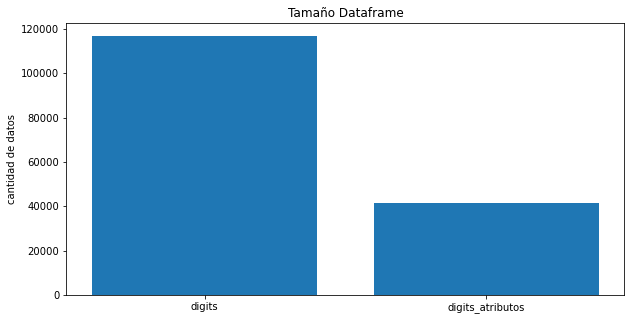

In [43]:
fig = plt.figure(figsize=(10,5))
plt.bar(x =["digits", "digits_atributos"], height = [digits.size,digits_atributos.size])
plt.title("Tamaño Dataframe")
plt.ylabel("cantidad de datos")
plt.show()

In [44]:
X = digits.drop("target",axis = 1, inplace = False)
Y = digits["target"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
model3.fit(X_train, Y_train)
time_original = time.time() - start_time #tiempo en que se ejecutó el modelo con el dataset original
print(" El modelo se ejecutó en %s segundos con el DataFrame original." % (time_original)) 

 El modelo se ejecutó en 0.03889608383178711 segundos con el DataFrame original.


In [45]:
#Spliteo train-test con el dataframe digits_pca
X = digits_atributos.drop("target",axis=1)
y = digits["target"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
model3.fit(X_train, Y_train)
time_atributos = time.time() - start_time #tiempo en que se ejecutó el modelo con el dataset original
print(" El modelo se ejecutó en %s segundos con el DataFrame digits_atributos." % (time_atributos)) 

 El modelo se ejecutó en 0.030897140502929688 segundos con el DataFrame digits_atributos.


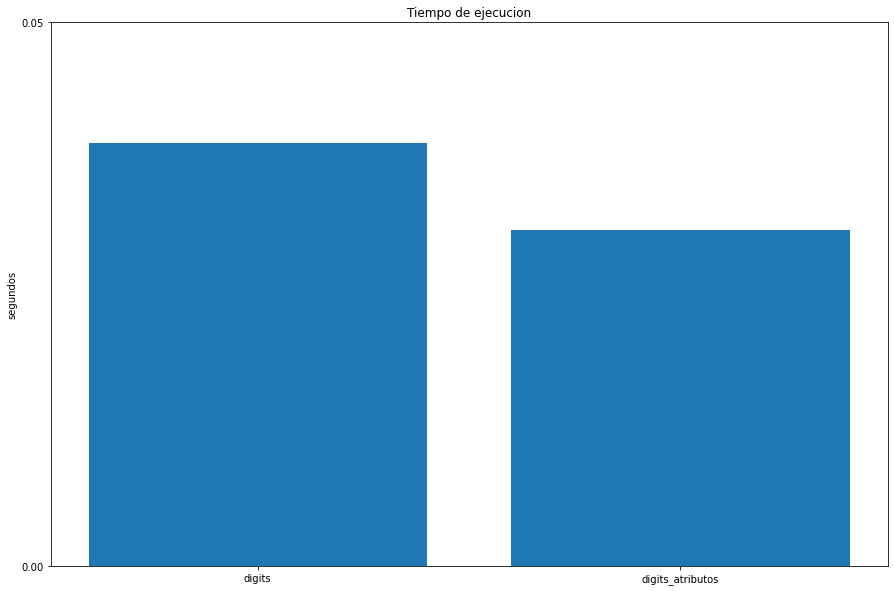

In [46]:
lista = [0.05 * i for i in range(2)]
fig = plt.figure(figsize=(15,10))
plt.bar(x = ['digits', 'digits_atributos'], height = [time_original, time_atributos])
plt.yticks(lista)
plt.title('Tiempo de ejecucion')
plt.ylabel('segundos')
plt.show()

### Extracción de atributos

In [47]:
#Se estandarizan los datos pues pca es suceptible a la distribucion de los datos
x = digits.drop("target",axis =1).values
y = digits["target"].values

x = StandardScaler().fit_transform(x)

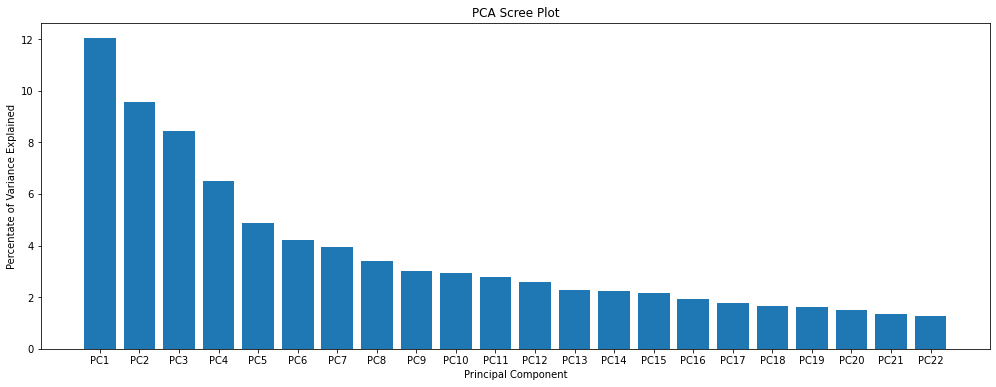

In [48]:
# Se ajusta el modelo 
from sklearn.decomposition import PCA
n_components = 22
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x)

# graficar varianza por componente
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = [f"PC{i}" for i in range(1,n_components+1)]

plt.figure(figsize=(17,6))
plt.bar(x= range(1,n_components+1), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

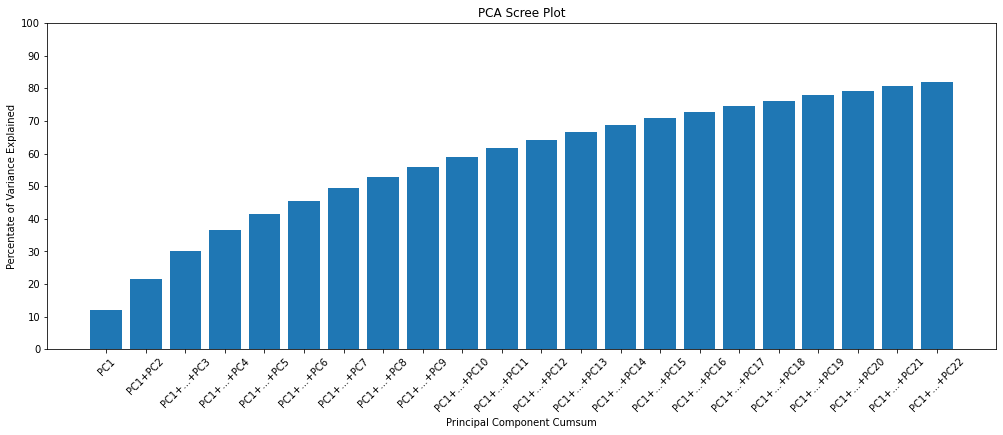

In [49]:
# graficar varianza por la suma acumulada de los componente
percent_variance_cum = np.cumsum(percent_variance)
columns_sum =[f"PC1+...+PC{i+1}" for i in range(2,n_components)]
columns_sum = ["PC1", "PC1+PC2"] + columns_sum

plt.figure(figsize=(17,6))
plt.bar(x= range(1,n_components+1), height=percent_variance_cum, tick_label=columns_sum)
plt.ylabel('Percentate of Variance Explained')
plt.yticks([10*i for i in range(11)])
plt.xlabel('Principal Component Cumsum')
plt.xticks(rotation =45)
plt.title('PCA Scree Plot')
plt.show()

In [50]:
principalDataframe = pd.DataFrame(data = principalComponents, columns = columns)
targetDataframe = digits[['target']]

digits_pca = pd.concat([principalDataframe, targetDataframe],axis = 1)
digits_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,target
0,1.914218,-0.954508,-3.946049,2.028737,-0.267148,0.530071,-1.415178,1.496088,0.124772,-0.821707,...,-0.192857,0.839505,0.104952,0.185086,-0.070617,0.404528,0.421427,0.484164,-0.573959,0
1,0.588989,0.924636,3.924735,-1.779858,-0.993694,-0.676153,1.879670,0.558108,1.080242,0.091340,...,-0.386219,-0.741472,-0.208647,-0.068341,-0.379917,0.573031,-0.081588,0.872863,0.157772,1
2,1.302034,-0.317188,3.023355,-2.043358,-2.080978,0.935556,-1.296879,1.155027,0.786084,-1.100924,...,-1.001227,-1.175463,0.401332,-0.263648,-0.489004,-1.067061,-1.140991,-0.496918,-0.027703,2
3,-3.020766,-0.868786,-0.801758,-2.187014,-0.556514,0.726732,0.959408,-1.382723,0.258271,0.743230,...,1.013049,-0.135626,-1.002769,-0.964316,-0.377296,1.468193,0.303516,0.616200,0.207424,3
4,4.528931,-1.093459,0.973136,-1.419579,-1.715465,1.432601,1.073362,-0.968482,-1.659408,1.173900,...,-0.124453,0.723250,0.208476,-0.077032,-0.608910,1.659941,1.133968,0.376385,0.167487,4


In [51]:
print("digits Original tiene", digits.size, "elementos")
print("digits_atributos tiene", digits_pca.size, "elementos")

digits Original tiene 116805 elementos
digits_atributos tiene 41331 elementos


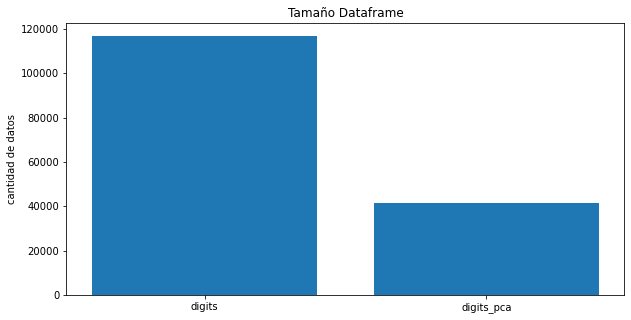

In [52]:
fig = plt.figure(figsize=(10,5))
plt.bar(x =["digits", "digits_pca"], height = [digits.size, digits_pca.size])
plt.title("Tamaño Dataframe")
plt.ylabel("cantidad de datos")
plt.show()

In [53]:
X = digits.drop("target",axis = 1, inplace = False)
Y = digits["target"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
model3.fit(X_train, Y_train)
# Se presenta el tiempo en que se ejecutó el modelo con el dataset original
time_original = time.time() - start_time
print(" El modelo se ejecutó en %s segundos con el DataFrame Original" % (time_original)) 

 El modelo se ejecutó en 0.03392982482910156 segundos con el DataFrame Original


In [54]:
#Spliteo train-test con el dataframe digits_pca
X = digits_pca.drop("target",axis=1, inplace = False)
y = digits["target"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
model3.fit(X_train, y_train)
# Se presenta el tiempo en que se ejecutó el modelo con el dataframe digits_pca
time_pca = time.time() - start_time
print(" El modelo se ejecutó en %s segundos con el DataFrame digits_pca" % (time_pca)) 

 El modelo se ejecutó en 0.034906625747680664 segundos con el DataFrame digits_pca


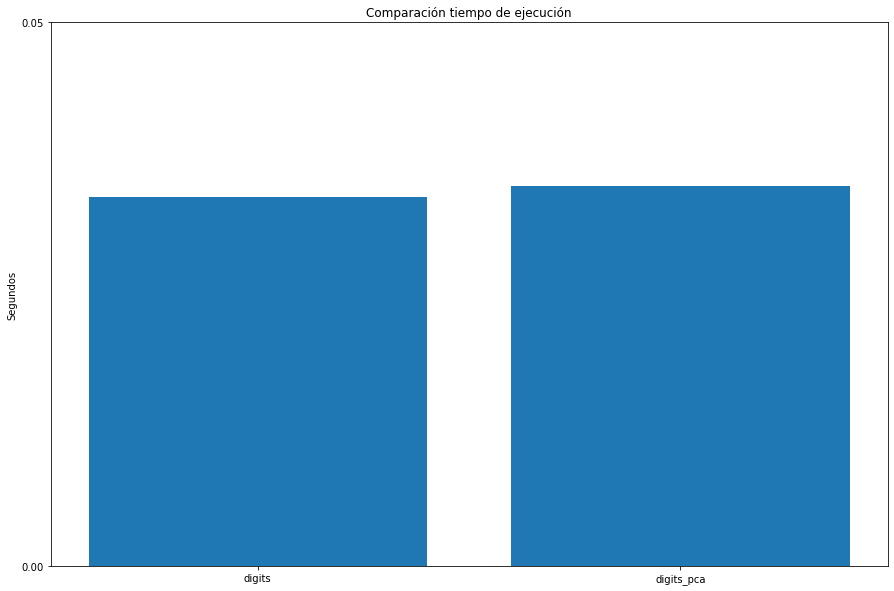

In [55]:
lista = [0.05 * i for i in range(2)]
fig = plt.figure(figsize=(15,10))
plt.bar(x = ['digits', 'digits_pca'], height = [time_original,time_pca])
plt.yticks(lista)
plt.title('Comparación tiempo de ejecución')
plt.ylabel('Segundos')
plt.show()

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [56]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = model.predict(X_test)
    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == Y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != Y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = Y_test[mask]
    y_aux_pred = y_pred[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            if index < X_aux.shape[0]:
                data  = X_aux[index, :].reshape(8,8)
                label_pred = str(int(y_aux_pred[index]))
                label_true = str(int(y_aux_true[index]))
                ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
                ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
                ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
                ax[i][j].get_xaxis().set_visible(False)
                ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

In [57]:
model = gs3

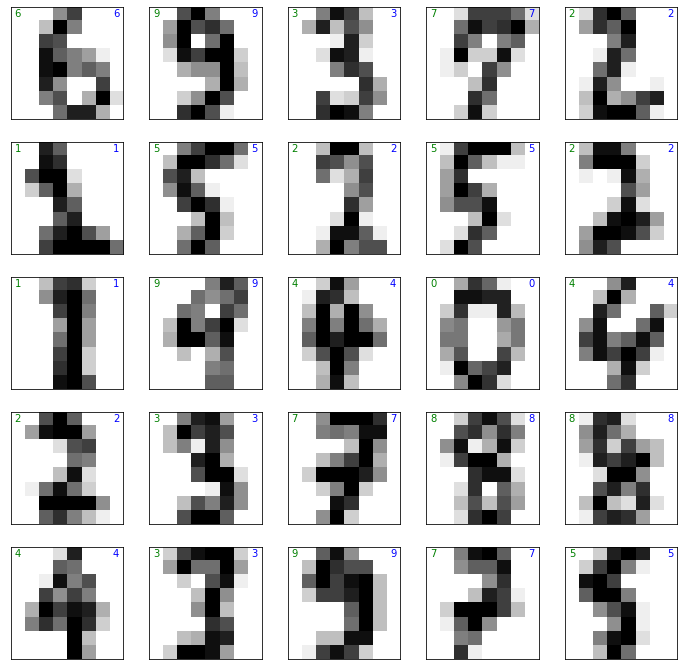

In [58]:
mostar_resultados(digits, model = model ,nx=5, ny=5,label = "correctos")

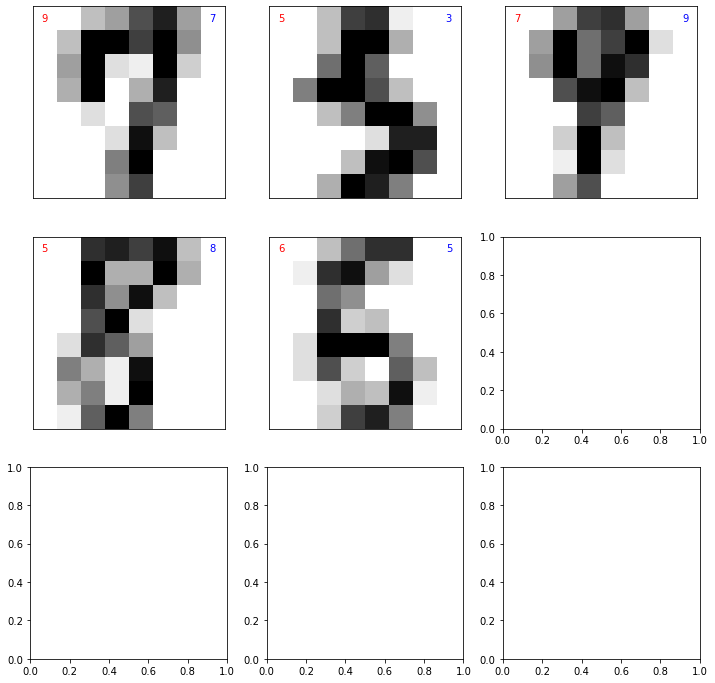

In [59]:
mostar_resultados(digits,model = mejor_modelo3 ,nx=3, ny=3,label = "incorrectos")

Estas fallas ocurren cuando el número que se queria expresar no esta bien "definido" o esta "confuso", es decir, que visualmente se ven como otro número y cuesta distinguirlo.

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

Concluimos que el mejor ajuste fue el SVC ya que obtuvo las mejores metricas.
Las preguntas iniciales se fueron respondiendo a lo largo del desarrollo del problema.
Para un futuro seria bueno realizar mejores pruebas, me refiero con respecto a las imagenes de los numeros que sean mas definidas.
La dificultad que tuvo el ajuste fue eso anterior, el hecho de que las imagenes no estuvieran tan definidas perjudico al ajuste pero sin embargo, es bastante bueno tambien.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [60]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 1. Definición del problema

Los datos pertenecen a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

El objetivo es poder predecir el valor promedio de cada propiedad.

### 2. Estadística descriptiva

In [61]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


#### ¿Cuantos datos hay?

In [62]:
print("Hay", housing.size, "en el dataframe.")

Hay 206400 en el dataframe.


####  ¿Cual es la forma del dataframe? ¿Cuantas columnas y filas tiene?

In [63]:
housing.shape
print("La forma del dataframe es:",housing.shape)
print("Tiene", housing.shape[0], "filas.")
print("Tiene", housing.shape[1], "columnas.")

La forma del dataframe es: (20640, 10)
Tiene 20640 filas.
Tiene 10 columnas.


### 3. Visualización descriptiva

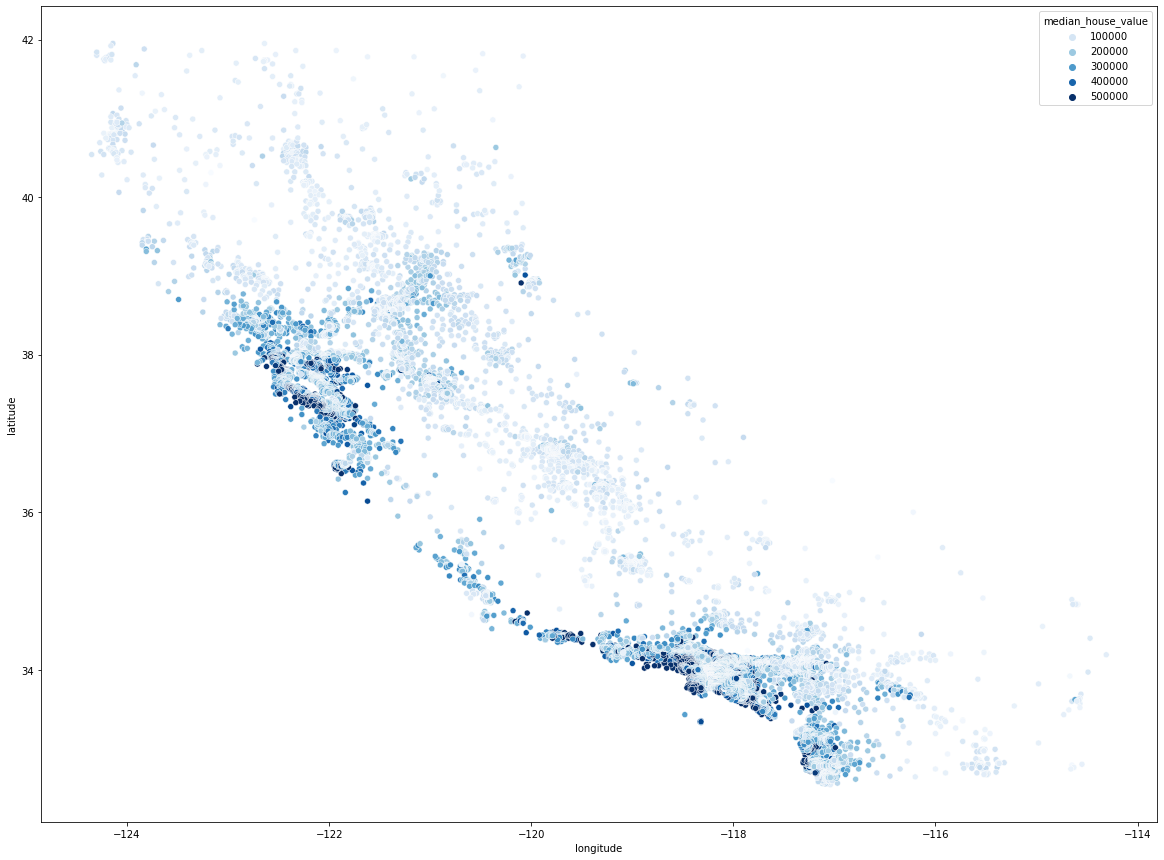

In [64]:
plt.figure(figsize=(20,15))
sns.scatterplot(x=housing.longitude, y=housing.latitude, hue=housing["median_house_value"], palette='Blues')
plt.show()

#### ¿Que tan cerca estan las casas del oceano o mar?

In [65]:
lista = housing['ocean_proximity'].unique()
lista

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [66]:
casas = housing.groupby('ocean_proximity')  
ocean_proximity = casas[['longitude']].count().reset_index()
ocean_proximity 

,ocean_proximity,longitude
0,<1H OCEAN,9136
1,INLAND,6551
2,ISLAND,5
3,NEAR BAY,2290
4,NEAR OCEAN,2658


<BarContainer object of 5 artists>

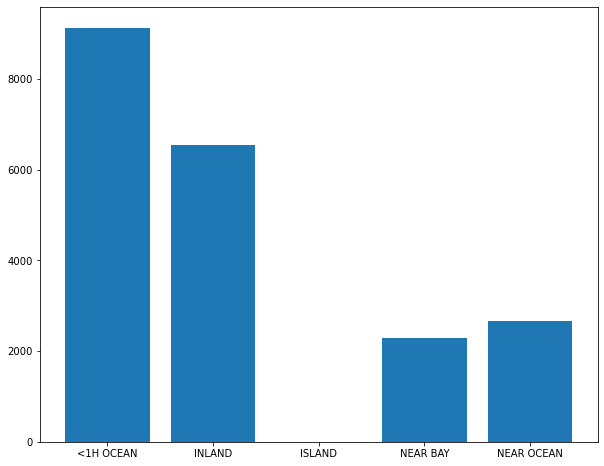

In [67]:
fig = plt.figure(figsize=(10, 8))
plt.bar(
    ocean_proximity["ocean_proximity"], # eje x
    ocean_proximity["longitude"], # eje y 
)

observacion: La columna "ISLAND" parecia que no tuviese datos en el grafico pero si tiene, lo que pasa es que las demas columnas tienen muchos, entonces no se alcanza a apreciar.

In [68]:
casas = housing.groupby('housing_median_age')  
housing_median_age = casas[['longitude']].count().reset_index()
housing_median_age

,housing_median_age,longitude
0,1.0,4
1,2.0,58
2,3.0,62
3,4.0,191
4,5.0,244
5,6.0,160
6,7.0,175
7,8.0,206
8,9.0,205
9,10.0,264


<BarContainer object of 52 artists>

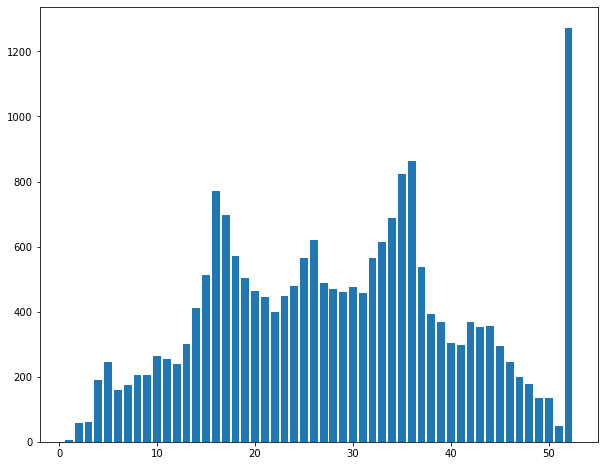

In [69]:
fig = plt.figure(figsize=(10, 8))
plt.bar(
    housing_median_age['housing_median_age'], # eje x: edad media de las casas
    housing_median_age["longitude"], # eje y: cantidad de casas con esa edad
)

Es decir, existen mas casas de 52 años que de menos edad.

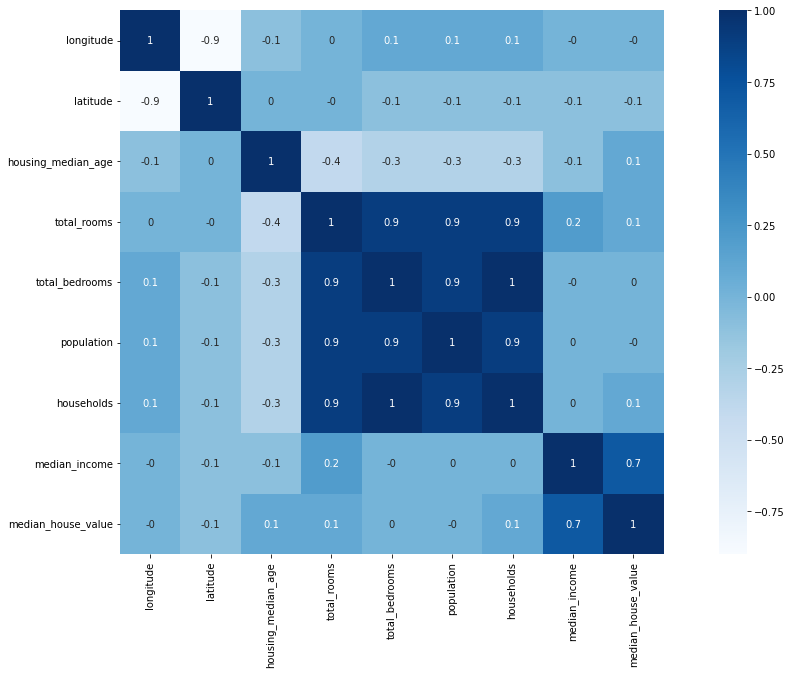

In [70]:
#matriz de correlacion
corr_mat=housing.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat.round(1),vmax=1,square=True,annot=True,cmap='Blues',fmt='g')
plt.show()

### 4. Preprocesamiento

In [71]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [72]:
housing['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [73]:
housing["ocean_proximity"] = housing["ocean_proximity"].replace({'NEAR BAY':1,'<1H OCEAN':2,'INLAND':3,'NEAR OCEAN':4,'ISLAND':5}) # target 

In [74]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [75]:
207/20640*100

1.002906976744186

In [76]:
housing = housing.dropna()

In [77]:
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

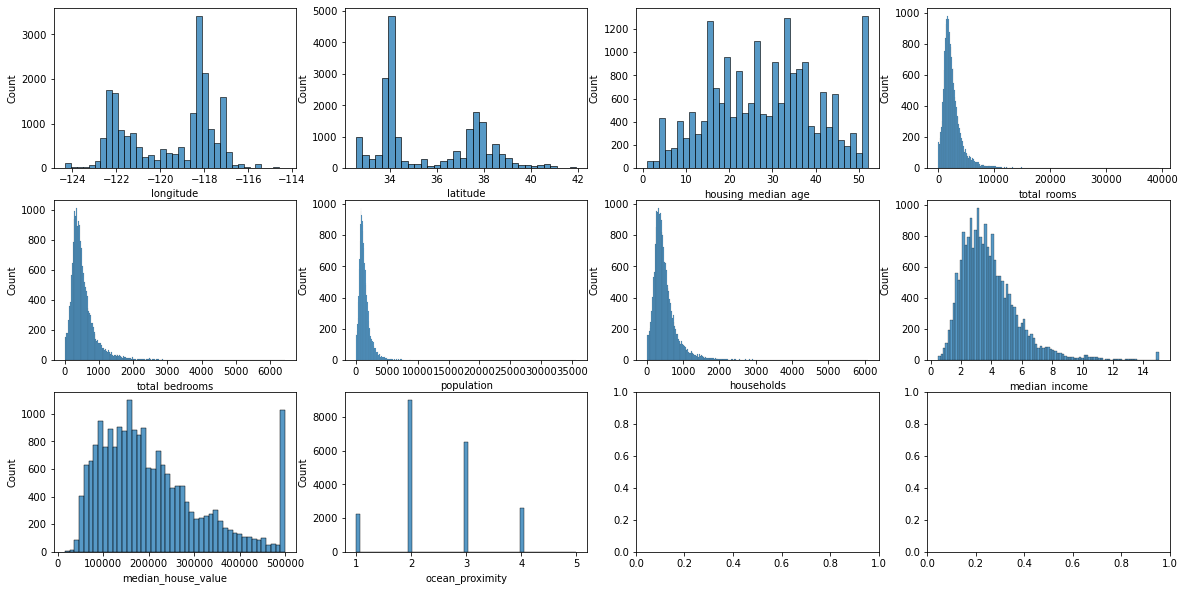

In [78]:
columnas = housing.columns # obtenemos cada columna del data

nx, ny = 3, 4
fig, axs = plt.subplots(nx,ny, figsize = (20,10))

for i in range(0,10): 
    plt.subplot(nx,ny,i+1)
    sns.histplot(housing[columnas[i]])

### 5. Selección de modelo, 6. Métricas y análisis de resultados y 7. Visualizaciones del modelo

Haremos el paso 5, 6 y 7 al mismo tiempo.

In [79]:
from metrics_regression import *
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [80]:
X = housing.drop(columns="median_house_value").values
Y = housing["median_house_value"].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [81]:
#Crear conjunto de entrenamiento y testeo
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=20)

In [82]:
#largo del conjunto de entrenamiento y de testeo
print('El train set tiene',len(X_train), 'filas.')
print('El test set tiene',len(X_test), 'filas.')

El train set tiene 14303 filas.
El test set tiene 6130 filas.


##### MODELO 1: RIDGE

In [83]:
# creación del modelo
model1 = Ridge()

param_grid1 = {'alpha':[10,15,20,30,70,50,12,13,14]}

# aplicar greed search
gs1 = GridSearchCV(estimator=model1, 
                  param_grid=param_grid1)

gs1 = gs1.fit(X_train, Y_train)

# imprimir resultados
print("Best: %f con %s" % (gs1.best_score_, gs1.best_params_))

Best: 0.634840 con {'alpha': 12}


In [84]:
# utilizando el mejor modelo
mejor_modelo1 = gs1.best_estimator_
#mejor_modelo1.fit(X_train, Y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo1.score(X_test, Y_test)))

Precisión: 0.636


In [85]:
Y_pred = mejor_modelo1.predict(X_test)#Predicción del modelo
print('Metricas:')
df1 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred
    }
)

df_metrics1 = summary_metrics(df1)
df_metrics1['r2'] =  round(r2_score(Y_test, Y_pred),4)

df_metrics1

Metricas:


,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,50627.1274,4.784253e+09,69168.2982,0.3086,0.2723,0.248,0.3086,0.2817,0.6358


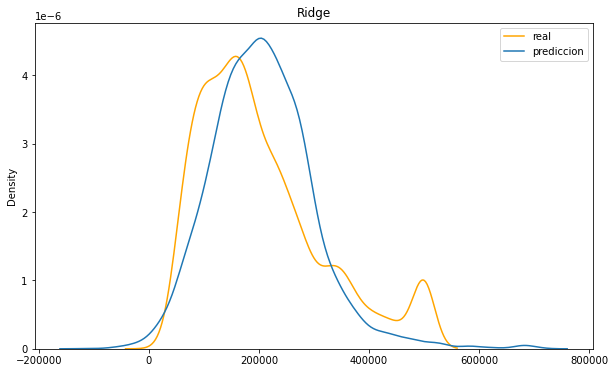

In [86]:
plt.figure(figsize=(10, 6))

ax = sns.distplot(Y_test, hist=False, color="orange", label="real")
sns.distplot(Y_pred, hist=False, label="prediccion" , ax=ax)

plt.title('Ridge')
plt.legend()
plt.show()

##### MODELO 2: K-NN

In [87]:
# creación del modelo
model2 = KNeighborsClassifier()

# rango de parametros
param_grid2 = {
          'n_neighbors' : [3, 6, 15,30,100,1,150,10,12,22]}

# aplicar greed search
gs2 = GridSearchCV(estimator=model2, 
                  param_grid=param_grid2)

gs2 = gs2.fit(X_train, Y_train)

# imprimir resultados
print("Best: %f con %s" % (gs2.best_score_, gs2.best_params_))

Best: 0.049430 con {'n_neighbors': 150}


In [88]:
# utilizando el mejor modelo
mejor_modelo2 = gs2.best_estimator_
#mejor_modelo1.fit(X_train, Y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo2.score(X_test, Y_test)))

Precisión: 0.044


In [89]:
Y_pred = mejor_modelo2.predict(X_test)#Predicción del modelo
print('Metricas:')
df2 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred
    }
)

df_metrics2 = summary_metrics(df2)
df_metrics2['r2'] =  round(r2_score(Y_test, Y_pred),4)

df_metrics2

Metricas:


,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,88615.7423,1.761897e+10,132736.4746,0.4653,0.3576,0.4341,0.4653,0.3691,-0.3413


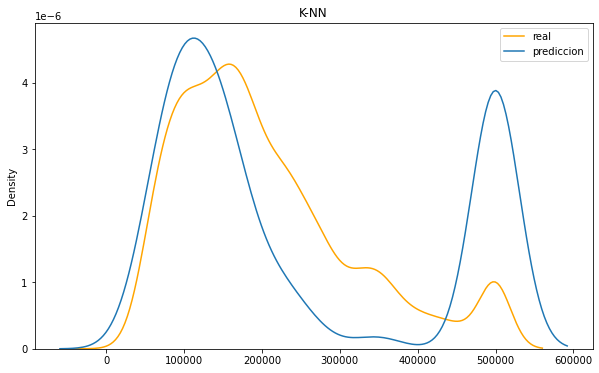

In [90]:
plt.figure(figsize=(10, 6))

ax = sns.distplot(Y_test, hist=False, color="orange", label="real")
sns.distplot(Y_pred, hist=False, label="prediccion" , ax=ax)

plt.title('K-NN')
plt.legend()
plt.show()

##### MODELO 3: LASSO

In [91]:
# creación del modelo
model3 = Lasso()

# rango de parametros
param_grid3 = {'alpha':[10,20,30,50,60,70,80]}

# aplicar greed search
gs3 = GridSearchCV(estimator=model3, 
                  param_grid=param_grid3)

gs3 = gs3.fit(X_train, Y_train)

# imprimir resultados
print("Best: %f con %s" % (gs3.best_score_, gs3.best_params_))

Best: 0.634841 con {'alpha': 70}


In [92]:
# utilizando el mejor modelo
mejor_modelo3 = gs3.best_estimator_
#mejor_modelo1.fit(X_train, Y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo3.score(X_test, Y_test)))

Precisión: 0.636


In [93]:
Y_pred = mejor_modelo3.predict(X_test)#Predicción del modelo
print('Metricas:')
df3 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred
    }
)

df_metrics3 = summary_metrics(df3)
df_metrics3['r2'] =  round(r2_score(Y_test, Y_pred),4)

df_metrics3

Metricas:


,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,50641.1317,4.785154e+09,69174.8045,0.3088,0.2724,0.2481,0.3088,0.2819,0.6357


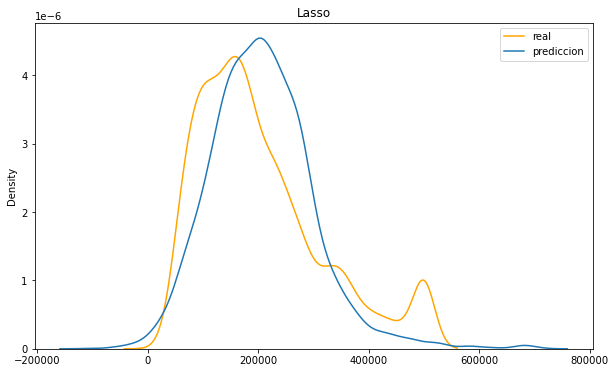

In [94]:
plt.figure(figsize=(10, 6))

ax = sns.distplot(Y_test, hist=False, color="orange", label="real")
sns.distplot(Y_pred, hist=False, label="prediccion" , ax=ax)

plt.title('Lasso')
plt.legend()
plt.show()

##### MODELO 4: Decision Tree Regressor

In [95]:
from sklearn.tree import DecisionTreeRegressor

In [96]:
# creación del modelo
model4 = DecisionTreeRegressor()

# rango de parametros
param_grid4 = {'max_depth': [7,10,1,0.7,50,0.01], 
          'max_features': ['auto', 'sqrt'], 
          'min_samples_leaf': [7,10,1,0.7,50,0.01], 
          'min_samples_split': [7,10,1,0.7,50,0.01],
          'criterion': ['mse'] 
         }

# aplicar greed search
gs4 = GridSearchCV(estimator=model4, 
                  param_grid=param_grid4)

gs4 = gs4.fit(X_train, Y_train)

# imprimir resultados
print("Best: %f con %s" % (gs4.best_score_, gs4.best_params_))

Best: 0.720000 con {'criterion': 'mse', 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 50}


In [97]:
# utilizando el mejor modelo
mejor_modelo4 = gs4.best_estimator_
#mejor_modelo1.fit(X_train, Y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo4.score(X_test, Y_test)))

Precisión: 0.739


In [98]:
Y_pred = mejor_modelo4.predict(X_test)#Predicción del modelo
print('Metricas:')
df4 = pd.DataFrame(
    {
        'y': Y_test,
        'yhat': Y_pred
    }
)

df_metrics4 = summary_metrics(df4)
df_metrics4['r2'] =  round(r2_score(Y_test, Y_pred),4)

df_metrics4

Metricas:


,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2
0,38767.0101,3.434163e+09,58601.7297,0.2151,0.1955,0.1899,0.2151,0.1967,0.7386


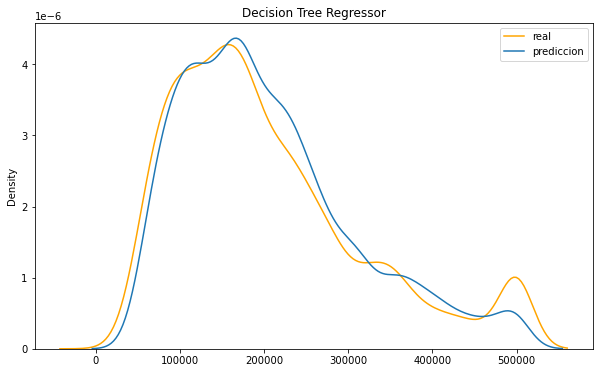

In [99]:
y_pred = gs4.predict(X_test)
plt.figure(figsize=(10, 6))

ax = sns.distplot(Y_test, hist=False, color="orange", label="real")
sns.distplot(Y_pred, hist=False, label="prediccion" , ax=ax)

plt.title('Decision Tree Regressor')
plt.legend()
plt.show()

### 8. Conclusiones

In [100]:
comparar = pd.concat([df_metrics1,df_metrics2,df_metrics3,df_metrics4])
comparar["model"] = ["Ridge","K-NN","Lasso","Decision Tree Regressor"]
comparar

,mae,mse,rmse,mape,maape,wmape,mmape,smape,r2,model
0,50627.1274,4.784253e+09,69168.2982,0.3086,0.2723,0.2480,0.3086,0.2817,0.6358,Ridge
0,88615.7423,1.761897e+10,132736.4746,0.4653,0.3576,0.4341,0.4653,0.3691,-0.3413,K-NN
0,50641.1317,4.785154e+09,69174.8045,0.3088,0.2724,0.2481,0.3088,0.2819,0.6357,Lasso
0,38767.0101,3.434163e+09,58601.7297,0.2151,0.1955,0.1899,0.2151,0.1967,0.7386,Decision Tree Regressor


El mejor ajuste fue realizado con Decision Tree Regressor que es el que tiene mejor r2. Es el que mejor puede predecir el valor promedio de cada propiedad.